# Лабораторная работа №6 (дополнительная). Решение уравнения эллиптического типа.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

## 1. Постановка задачи

Рассматривается задача о нагревании балки квадратного сечения ABCD, бесконечной по одной оси координат (Oz), как показано на рис. П2.6.

**Геометрия и параметры:**
*   Форма сечения: квадрат ABCD.
*   Размер грани: L = 0.1 м.
*   Характеристическая температура для пересчета относительных единиц: T* = 100 °C.

**Уравнение теплопроводности:**
Задача описывается стационарным уравнением теплопроводности (уравнением Лапласа), поскольку нет внутренних источников тепла и рассматривается установившийся режим: \
∂²u/∂x² + ∂²u/∂y² = 0 (П2.35) \
где `u(x,y)` – распределение температуры в сечении балки.

**Граничные условия:**
Температура на гранях поддерживается постоянной (задана в относительных единицах):
*   Грань AB (соответствует x=0): `u = 1`
*   Грань BC (соответствует y=L): `u = 2`
*   Грань CD (соответствует x=L): `u = 3`
*   Грань DA (соответствует y=0): `u = 4`

**Цель:**
Получить численное решение стационарной задачи теплопроводности, т.е. найти распределение температуры `u(x,y)` внутри квадрата.

## 2. Применяемые численные схемы

Для численного решения уравнения Лапласа используется метод конечных разностей. Область решения (квадрат) разбивается на равномерную сетку с шагами `hx` по оси x и `hy` по оси y. В данной задаче принимается `hx = hy = h`.

Уравнение Лапласа аппроксимируется стандартной пятиточечной разностной схемой для внутренних узлов сетки `(m,l)` или `(i,j)`:
$(u_{m-1,l} - 2u_{m,l} + u_{m+1,l})/h²_x + (u_{m,l-1} - 2u_{m,l} + u_{m,l+1})/h²_y = 0$

При `hx = hy = h` и `f_ml = 0` (для уравнения Лапласа), выражение для `u_{m,l}` (или `u_{i,j}`) принимает вид:
$u_{m,l} = 0.25 * (u_{m-1,l} + u_{m+1,l} + u_{m,l-1} + u_{m,l+1})$

Эта система линейных алгебраических уравнений решается итерационными методами.

In [2]:
# --- Problem Parameters ---
L = 0.1  # meters
T_star = 100.0  # C

# Boundary conditions
T_AB = 1.0  # Left edge (x=0) U[:,0]
T_BC = 2.0  # Top edge (y=L) U[N-1,:]
T_CD = 3.0  # Right edge (x=L) U[:,N-1]
T_DA = 4.0  # Bottom edge (y=0) U[0,:]

# --- Numerical Parameters ---
N = 41  # Number of grid points in each direction (Nx = Ny = N)
hx = L / (N - 1)
hy = L / (N - 1) # Since hx = hy = h

tolerance = 1e-5  # Convergence tolerance
max_iterations = 10000 # Max iterations to prevent infinite loops

omega_optimal = 2 / (1 + np.sin(np.pi / (N - 1)))
omega = omega_optimal

In [3]:
# --- Initialization ---
def initialize_grid(N_pts):
    U = np.zeros((N_pts, N_pts))
    U[:, 0] = T_AB
    U[N_pts-1, :] = T_BC
    U[:, N_pts-1] = T_CD
    U[0, :] = T_DA
    avg_bc = (T_AB + T_BC + T_CD + T_DA) / 4.0
    U[1:N_pts-1, 1:N_pts-1] = avg_bc
    return U

### а) Метод Якоби

В методе Якоби значение температуры `u` в узле `(m,l)` на новой `(i+1)`-й итерации вычисляется с использованием значений из предыдущей `i`-й итерации для всех соседних узлов: \
$u^{i+1}_{m,l} = (u^i_{m-1,l} + u^i_{m+1,l} + u^i_{m,l-1} + u^i_{m,l+1}) / 4$

### б) Метод Зейделя (Гаусса-Зейделя)

Метод Зейделя отличается от метода Якоби тем, что при вычислении $u^{i+1}_{m,l}$ используются уже обновленные на текущей `(i+1)`-й итерации значения для тех соседей, которые были вычислены ранее в текущей итерации (обычно $u^{i+1}_{m-1,l}$ и $u^{i+1}_{m,l-1}$ при стандартном порядке обхода сетки). Значения для остальных соседей ($u^i_{m+1,l}$ и $u^i_{m,l+1}$) берутся из предыдущей `i`-й итерации. \
Формула выглядит так же, как для Якоби, но подразумевается, что значения справа берутся самые "свежие" из доступных: \
$u^{i+1}_{m,l} = (u^{обновл.}_{m-1,l} + u^{старое}_{m+1,l} + u^{обновл.}_{m,l-1} + u^{старое}_{m,l+1}) / 4$
Это достигается обновлением массива значений температуры "на месте" в ходе итерации.

### в) Метод верхней релаксации (Successive Over-Relaxation, SOR)

Метод SOR является развитием метода Гаусса-Зейделя и предназначен для ускорения сходимости. Новое значение $u^{i+1}_{m,l}$ вычисляется как: \
$u^{i+1}_{m,l} = (1 - ω) * u^i_{m,l} + ω * u^{GS}_{m,l}$
где: 
*   $u^i_{m,l}$ – значение из предыдущей итерации.
*   $u^{GS}_{m,l}$ – значение, которое было бы получено на текущей итерации методом Гаусса-Зейделя:
    $u^{GS}_{m,l} = 0.25 * (u^{обновл.}_{m-1,l} + u^{старое}_{m+1,l} + u^{обновл.}_{m,l-1} + u^{старое}_{m,l+1})$
*   `ω` (в задании обозначен как `τ`) – параметр релаксации. Для сходимости обычно `0 < ω < 2`. При `ω = 1` метод SOR совпадает с методом Гаусса-Зейделя. Оптимальное значение `ω` часто лежит в интервале `(1, 2)`.

Формула (П2.38) для $hx = hy = h$ и $f_{ml} = 0$ может быть приведена к стандартному виду метода SOR.

**Процесс итераций:**
Для всех методов итерации продолжаются до тех пор, пока максимальное изменение значения температуры в любом узле сетки между двумя последовательными итерациями не станет меньше заданной малой величины (критерий сходимости `tolerance`).


In [4]:
# --- Solver Functions ---

def solve_jacobi(U_init, hx_val, hy_val, tol, max_iter):
    U = U_init.copy()
    N_pts = U.shape[0]
    iterations = 0
    history_max_diff = []

    for k in range(max_iter):
        U_old = U.copy()
        max_diff = 0.0
        for i in range(1, N_pts - 1):
            for j in range(1, N_pts - 1):
                U[i, j] = 0.25 * (U_old[i+1, j] + U_old[i-1, j] +
                                  U_old[i, j+1] + U_old[i, j-1])
                diff = abs(U[i,j] - U_old[i,j])
                if diff > max_diff:
                    max_diff = diff
        
        iterations += 1
        history_max_diff.append(max_diff)
        if max_diff < tol:
            break
    return U, iterations, history_max_diff

def solve_gauss_seidel(U_init, hx_val, hy_val, tol, max_iter):
    U = U_init.copy()
    N_pts = U.shape[0]
    iterations = 0
    history_max_diff = []

    for k in range(max_iter):
        max_diff_this_iteration = 0.0
        for i in range(1, N_pts - 1):
            for j in range(1, N_pts - 1):
                U_old_at_point_ij = U[i, j]
                U[i, j] = 0.25 * (U[i-1, j] + U[i+1, j] + U[i, j-1] + U[i, j+1])
                diff = abs(U[i, j] - U_old_at_point_ij)
                if diff > max_diff_this_iteration:
                    max_diff_this_iteration = diff
        
        iterations += 1
        history_max_diff.append(max_diff_this_iteration)
        if max_diff_this_iteration < tol:
            break
    return U, iterations, history_max_diff

def solve_sor(U_init, hx_val, hy_val, omega_val, tol, max_iter):
    U = U_init.copy()
    N_pts = U.shape[0]
    iterations = 0
    history_max_diff = []

    for k in range(max_iter):
        U_old_iter = U.copy() 
        max_diff = 0.0
        for i in range(1, N_pts - 1):
            for j in range(1, N_pts - 1):
                u_gs_component = 0.25 * (U_old_iter[i+1, j] + U[i-1, j] +
                                         U_old_iter[i, j+1] + U[i, j-1])
                U[i, j] = (1 - omega_val) * U_old_iter[i, j] + omega_val * u_gs_component
                diff = abs(U[i,j] - U_old_iter[i,j])
                if diff > max_diff:
                    max_diff = diff
        
        iterations += 1
        history_max_diff.append(max_diff)
        if max_diff < tol:
            break
    return U, iterations, history_max_diff

In [5]:
# --- Plotting Functions ---
def plot_isotherms(U, method_name, L_val, N_pts, T_s):
    x = np.linspace(0, L_val, N_pts)
    y = np.linspace(0, L_val, N_pts)
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(8, 6.5))
    contour = plt.contourf(X, Y, U * T_s, levels=20, cmap='jet')
    plt.colorbar(contour, label='Temperature (°C)')
    plt.contour(X, Y, U * T_s, levels=contour.levels, colors='k', linewidths=0.7)
    plt.title(f'Isotherms - {method_name} (N={N_pts})')
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def plot_1d_slices(U, method_name, L_val, N_pts, T_s):
    x_coords = np.linspace(0, L_val, N_pts)
    y_coords = np.linspace(0, L_val, N_pts)
    plt.figure(figsize=(12, 5))
    y_indices_for_plot = [N_pts // 4, N_pts // 2, 3 * N_pts // 4]
    plt.subplot(1, 2, 1)
    for iy_actual in y_indices_for_plot:
        plt.plot(x_coords, U[iy_actual, :] * T_s, label=f'y = {y_coords[iy_actual]:.3f} m')
    plt.title(f'{method_name}: T(x) at various y slices')
    plt.xlabel('x (m)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    x_indices_for_plot = [N_pts // 4, N_pts // 2, 3 * N_pts // 4]
    plt.subplot(1, 2, 2)
    for ix_actual in x_indices_for_plot:
        plt.plot(y_coords, U[:, ix_actual] * T_s, label=f'x = {x_coords[ix_actual]:.3f} m')
    plt.title(f'{method_name}: T(y) at various x slices')
    plt.xlabel('y (m)')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_convergence_history(histories, labels):
    plt.figure(figsize=(10, 6))
    for history, label in zip(histories, labels):
        plt.plot(history, label=label)
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Maximum Absolute Difference')
    plt.title('Convergence History')
    plt.legend()
    plt.grid(True, which="both", ls="-")
    plt.show()


--- Jacobi Method ---
Converged in 861 iterations (max_diff=9.97e-06 vs tol=1.0e-05). Time taken: 2.5292 seconds


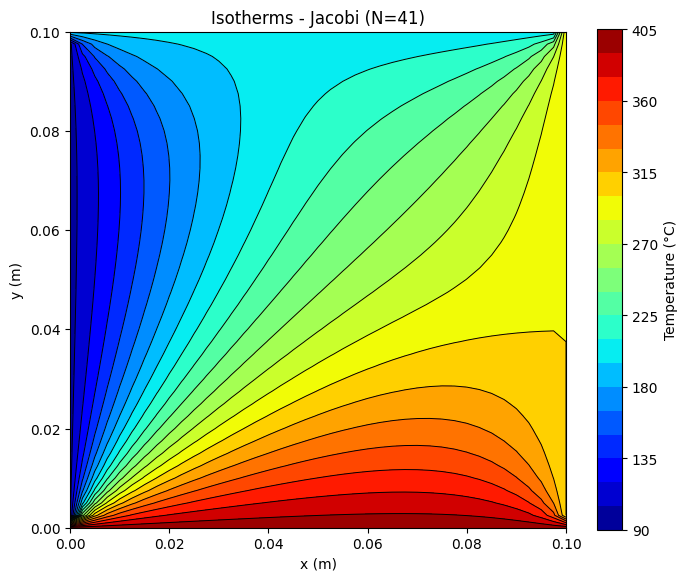

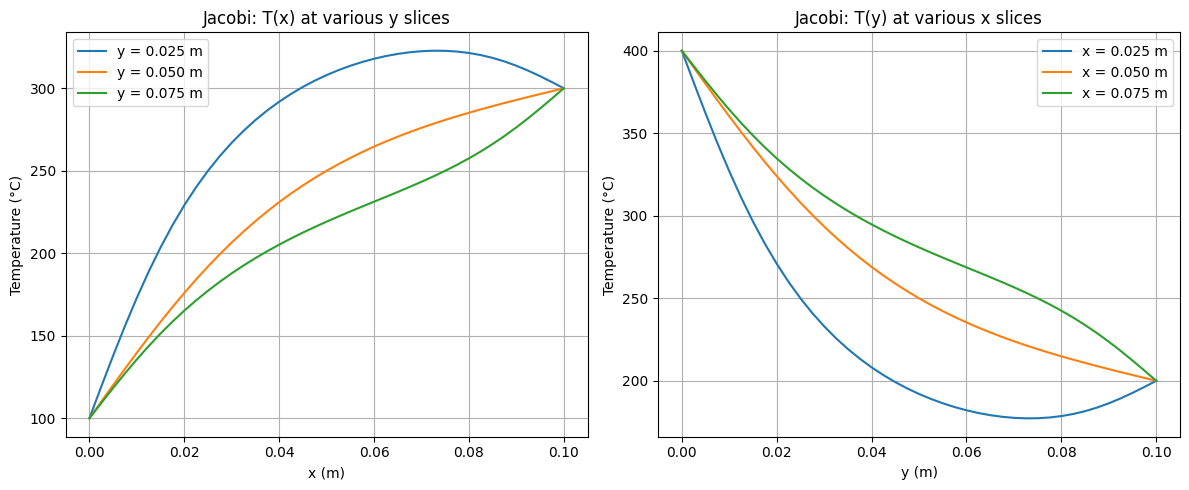


--- Gauss-Seidel Method ---
Converged in 473 iterations (max_diff=9.95e-06 vs tol=1.0e-05). Time taken: 1.2656 seconds


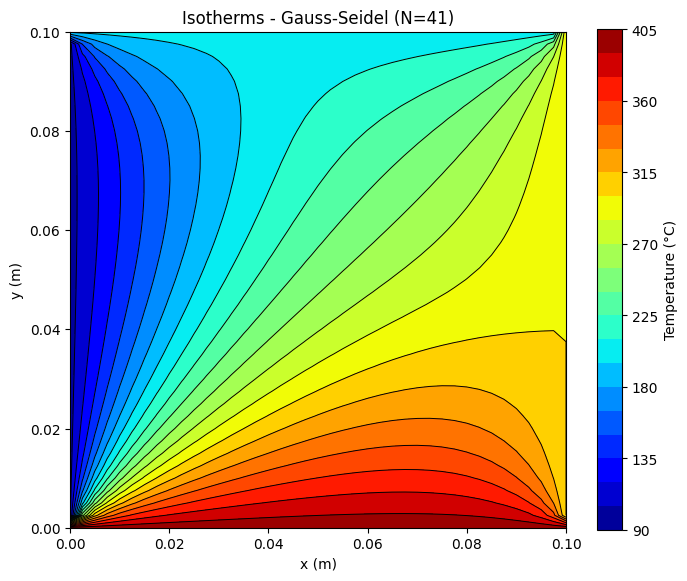

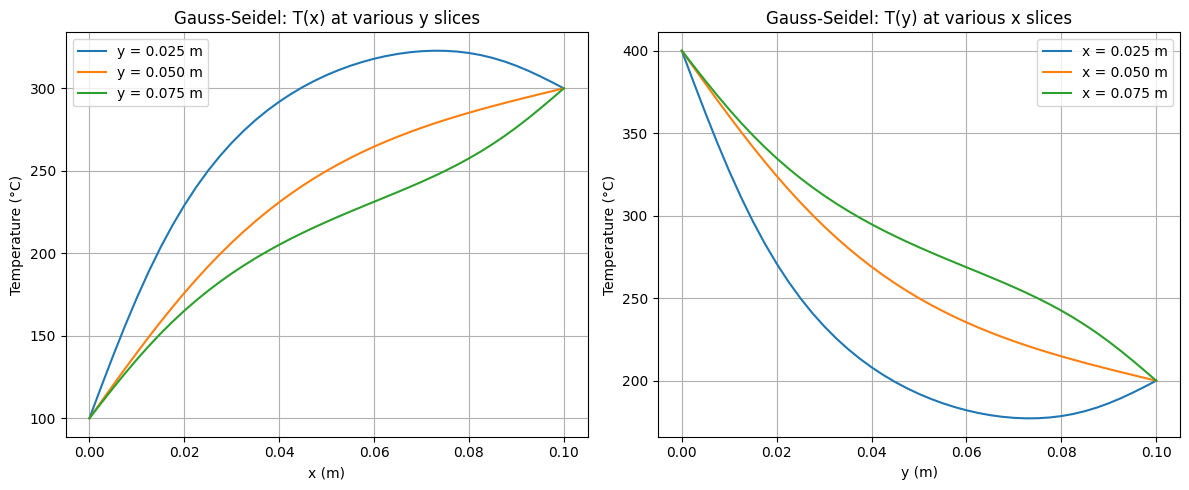


--- SOR Method (omega=1.8545) ---
Converged in 90 iterations (max_diff=9.56e-06 vs tol=1.0e-05). Time taken: 0.2991 seconds


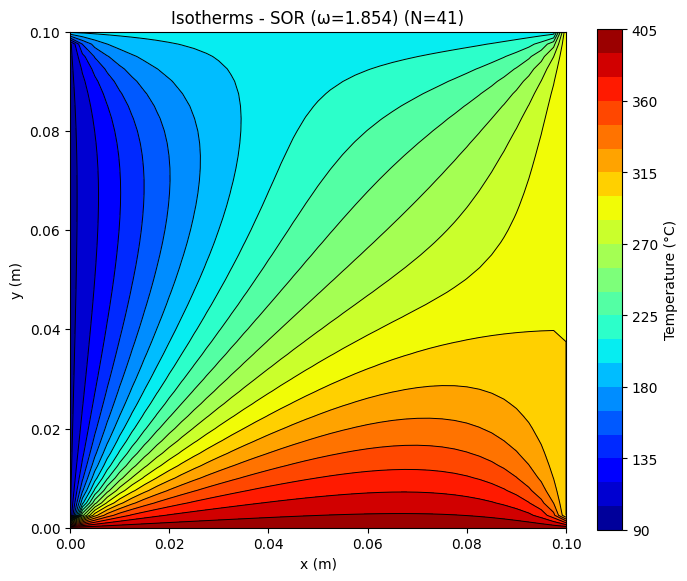

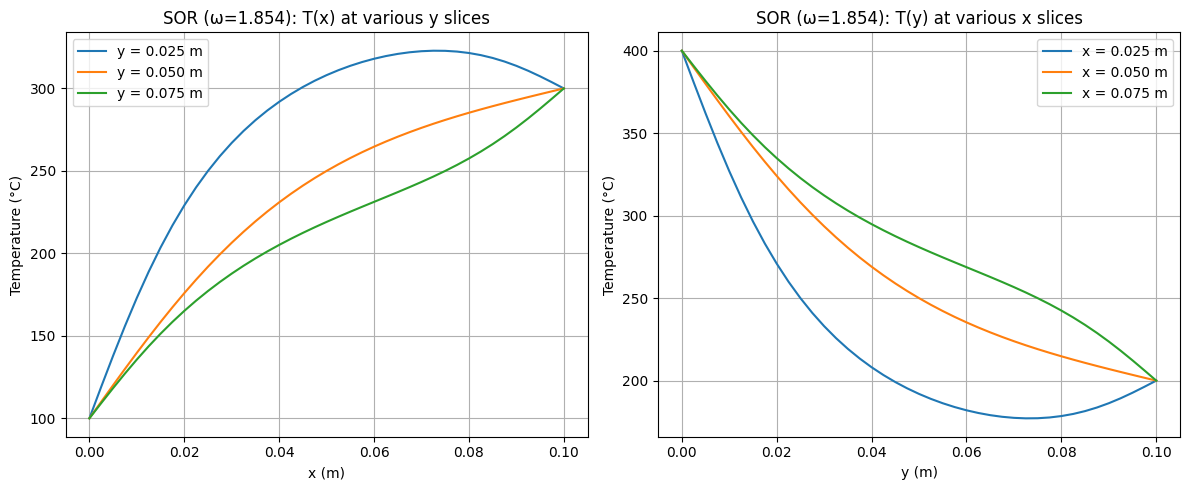


--- Convergence Summary ---
Jacobi: 861 iterations, 2.5292 s
Gauss-Seidel: 473 iterations, 1.2656 s
SOR (ω=1.854): 90 iterations, 0.2991 s


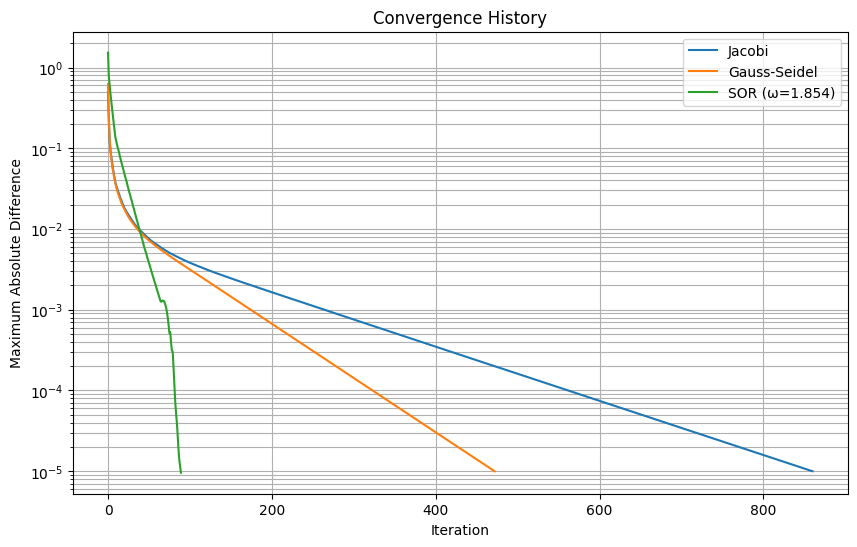

In [6]:
# --- Main Execution ---
if __name__ == "__main__":
    U_initial = initialize_grid(N)

    # --- Jacobi Method ---
    print("\n--- Jacobi Method ---")
    start_time = time.time()
    U_jacobi, iter_jacobi, hist_jacobi = solve_jacobi(U_initial.copy(), hx, hy, tolerance, max_iterations)
    time_jacobi = time.time() - start_time
    print(f"Converged in {iter_jacobi} iterations (max_diff={hist_jacobi[-1]:.2e} vs tol={tolerance:.1e}). Time taken: {time_jacobi:.4f} seconds")
    plot_isotherms(U_jacobi, "Jacobi", L, N, T_star)
    plot_1d_slices(U_jacobi, "Jacobi", L, N, T_star)

    # --- Gauss-Seidel Method ---
    print("\n--- Gauss-Seidel Method ---")
    start_time = time.time()
    U_gs, iter_gs, hist_gs = solve_gauss_seidel(U_initial.copy(), hx, hy, tolerance, max_iterations)
    time_gs = time.time() - start_time
    print(f"Converged in {iter_gs} iterations (max_diff={hist_gs[-1]:.2e} vs tol={tolerance:.1e}). Time taken: {time_gs:.4f} seconds")
    plot_isotherms(U_gs, "Gauss-Seidel", L, N, T_star)
    plot_1d_slices(U_gs, "Gauss-Seidel", L, N, T_star)

    # --- SOR Method ---
    print(f"\n--- SOR Method (omega={omega:.4f}) ---")
    start_time = time.time()
    U_sor, iter_sor, hist_sor = solve_sor(U_initial.copy(), hx, hy, omega, tolerance, max_iterations)
    time_sor = time.time() - start_time
    print(f"Converged in {iter_sor} iterations (max_diff={hist_sor[-1]:.2e} vs tol={tolerance:.1e}). Time taken: {time_sor:.4f} seconds")
    plot_isotherms(U_sor, f"SOR (ω={omega:.3f})", L, N, T_star)
    plot_1d_slices(U_sor, f"SOR (ω={omega:.3f})", L, N, T_star)
    
    # --- Compare Convergence Speeds ---
    print("\n--- Convergence Summary ---")
    print(f"Jacobi: {iter_jacobi} iterations, {time_jacobi:.4f} s")
    print(f"Gauss-Seidel: {iter_gs} iterations, {time_gs:.4f} s")
    print(f"SOR (ω={omega:.3f}): {iter_sor} iterations, {time_sor:.4f} s")

    plot_convergence_history(
        [hist_jacobi, hist_gs, hist_sor],
        ["Jacobi", "Gauss-Seidel", f"SOR (ω={omega:.3f})"]
    )

## Выводы
В данной лабораторной работе мы решили стационарное уравнение теплопроводности (эллиптический тип) при помощи итерационных методов Якоби, Зейделя и верхней релаксации. Как видно из графиков решений, все методы пришли к одному результату. Также отметим, что, как и ожидалось, по скорости сходимости методы расположились так: Якоби, Зейдель, верхняя релаксация (правильно подобранный параметр). Это отображено на последнем графике (история сходимости).